# Задание 10

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

# библиотека для обработки выбросов
from sklearn.ensemble import IsolationForest

# библиотеки для построение моделей
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# библиотеки для оценки качества моделей
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.metrics import recall_score

In [3]:
train = pd.read_excel('/content/train.xls', sheet_name='данные')
test = pd.read_excel('/content/test.xls', sheet_name='данные')

In [4]:
info = pd.read_excel('/content/train.xls', sheet_name='Описание полей')
info

ПОЛЕ  \
0                 AGREEMENT_RK   
1                       TARGET   
2                          AGE   
3            SOCSTATUS_WORK_FL   
4            SOCSTATUS_PENS_FL   
5                       GENDER   
6                  CHILD_TOTAL   
7                   DEPENDANTS   
8                    EDUCATION   
9               MARITAL_STATUS   
10                GEN_INDUSTRY   
11                   GEN_TITLE   
12                ORG_TP_STATE   
13             ORG_TP_FCAPITAL   
14                     JOB_DIR   
15               FAMILY_INCOME   
16             PERSONAL_INCOME   
17        REG_ADDRESS_PROVINCE   
18       FACT_ADDRESS_PROVINCE   
19     POSTAL_ADDRESS_PROVINCE   
20                 TP_PROVINCE   
21                   REGION_NM   
22                 REG_FACT_FL   
23                FACT_POST_FL   
24                 REG_POST_FL   
25            REG_FACT_POST_FL   
26         REG_FACT_POST_TP_FL   
27              FL_PRESENCE_FL   
28                    OWN_AUTO   
29                 AUTO_RUS_FL   
30              HS_PRESENCE_FL   
31             COT_PRESENCE_FL   
32             GAR_PRESENCE_FL   
33            LAND_PRESENCE_FL   
34                      CREDIT   
35                        TERM   
36                 FST_PAYMENT   
37              DL_DOCUMENT_FL   
38             GPF_DOCUMENT_FL   
39            FACT_LIVING_TERM   
40                   WORK_TIME   
41               FACT_PHONE_FL   
42                REG_PHONE_FL   
43                GEN_PHONE_FL   
44              LOAN_NUM_TOTAL   
45             LOAN_NUM_CLOSED   
46               LOAN_NUM_PAYM   
47                LOAN_DLQ_NUM   
48                LOAN_MAX_DLQ   
49            LOAN_AVG_DLQ_AMT   
50            LOAN_MAX_DLQ_AMT   
51  PREVIOUS_CARD_NUM_UTILIZED   

                                             ОПИСАНИЕ  
0          уникальный идентификатор объекта в выборке  
1   целевая переменная:отклик на маркетинговую кам...  
2                                     возраст клиента  
3   социальный статус клиента относительно работы ...  
4   социальный статус клиента относительно пенсии ...  
5                                         пол клиента  
6                            количество детей клиента  
7                       количество иждивенцев клиента  
8                                         образование  
9                                  семейное положение  
10                             отрасль работы клиента  
11                                          должность  
12                       форма собственности компании  
13                  отношение к иностранному капиталу  
14          направление деятельности в нутри компании  
15               семейный доход (несколько категорий)  
16                    личный доход клиента (в рублях)  
17                        область регистрации клиента  
18            область фактического пребывания клиента  
19                             почтовый адрес область  
20  область торговой точки, где клиент брал послед...  
21                                          регион РФ  
22  адрес регистрации и адрес фактического пребыва...  
23  адрес фактического пребывания клиента и его по...  
24  адрес регистрации клиента и его почтовый адрес...  
25  почтовый, фактический и адрес регистрации совп...  
26  область регистрации, фактического пребывания, ...  
27  наличие в собственности квартиры (1 - есть, 0 ...  
28                кол-во автомобилей в собственности   
29  наличие в собственности автомобиля российского...  
30  наличие в собственности загородного дома (1 - ...  
31  наличие в собственности котеджа (1 - есть, 0 -...  
32  наличие в собственности гаража (1 - есть, 0 - ...  
33  наличие в собственности земельного участка (1 ...  
34        сумма последнего кредита клиента (в рублях)  
35                                       срок кредита  
36                    первоначальный взнос (в рублях)  
37  в анкете клиент указал водительское удостовере...  
38  в анкете клиен указал ГПФ (1 - указ

Анализ исходных признаков:

• уникальный идентификатор объекта в выборке - не имеет значение для анализа, т.к. уникален для каждого значения;

• область регистрации зачастую совпадает с областью фактического пребывания, поэтому данные два признака очень сильно коррелированы. Имеет смысл оставить либо один из них, либо (преимущественно) оставить признак REG_FACT_FL, отвечающий за совпадение и несовпадение адресов (т.е. удаляем REG_ADDRESS_PROVINCE и FACT_ADDRESS_PROVINCE);

• почтовый адрес и все связанные с ним признаки не несут информации для анализа (т.е. удаляем POSTAL_ADDRESS_PROVINCE, FACT_POST_FL, REG_POST_FL, REG_FACT_POST_FL). Признак REG_FACT_POST_TP_FL может быть полезен. Необходимо посмотреть на матрицу корреляций;

• область торговой точки и регион РФ имеют 100% корреляцию друг с другом, поэтому необходимо оставить один из признаков. С одной стороны, лучше взять тот признак, у которого меньше уникальных значений (то есть регион РФ), чтобы избежать переобучения модели. С другой строны, особенности областей могут не совпадать с особенностями региона в целом, поэтому выбор региона в качестве признака может привести к потери некоторой информации. Удаляем регион REGION_NM.

• номер максимальной просрочки LOAN_MAX_DLQ - не имеет значение для анализа, т.к. всего лишь номер, не сумма.

Остальные признаки есть смысл пока что оставить на рассмотрении.

In [5]:
to_delete = ['AGREEMENT_RK', 'REG_ADDRESS_PROVINCE',
            'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE',
            'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
            'REGION_NM', 'LOAN_MAX_DLQ']

# Разведочный анализ данных

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AGREEMENT_RK                15223 non-null  int64  
 1   TARGET                      15223 non-null  int64  
 2   AGE                         15223 non-null  int64  
 3   SOCSTATUS_WORK_FL           15223 non-null  int64  
 4   SOCSTATUS_PENS_FL           15223 non-null  int64  
 5   GENDER                      15223 non-null  int64  
 6   CHILD_TOTAL                 15223 non-null  int64  
 7   DEPENDANTS                  15223 non-null  int64  
 8   EDUCATION                   15223 non-null  object 
 9   MARITAL_STATUS              15223 non-null  object 
 10  GEN_INDUSTRY                13856 non-null  object 
 11  GEN_TITLE                   13856 non-null  object 
 12  ORG_TP_STATE                13856 non-null  object 
 13  ORG_TP_FCAPITAL             138

## Обработка пропущенных значений

In [7]:
# пропуски в данных
for feature in train.columns:
    if feature not in to_delete:
        mean = train[feature].isnull().mean()
        if mean:
            print(feature, round(mean, 3))

GEN_INDUSTRY 0.09
GEN_TITLE 0.09
ORG_TP_STATE 0.09
ORG_TP_FCAPITAL 0.09
JOB_DIR 0.09
TP_PROVINCE 0.019
WORK_TIME 0.09
PREVIOUS_CARD_NUM_UTILIZED 0.981


Признак PREVIOUS_CARD_NUM_UTILIZED имеет очень много пропущенных значений (98%) - его надо исключить.

Остальные признаки имеют пропуски в пределах 10% - их необходимо обработать.

Для этого посмотрим на уникальные значения категориальных признаков

In [8]:
dct = {}
for column in list(train.select_dtypes(['object']).columns):
    if column not in to_delete:
        dct[column] = train[column].unique()
        print(column, dct[column], end='\n\n')

EDUCATION ['Среднее специальное' 'Среднее' 'Неполное среднее' 'Высшее'
 'Неоконченное высшее' 'Два и более высших образования' 'Ученая степень']

MARITAL_STATUS ['Состою в браке' 'Гражданский брак' 'Разведен(а)' 'Не состоял в браке'
 'Вдовец/Вдова']

GEN_INDUSTRY ['Торговля' 'Информационные технологии' 'Образование'
 'Государственная служба' 'Другие сферы' 'Сельское хозяйство'
 'Здравоохранение' 'Металлургия/Промышленность/Машиностроение' nan
 'Коммунальное хоз-во/Дорожные службы' 'Строительство' 'Транспорт'
 'Банк/Финансы' 'Ресторанный бизнес/Общественное питание' 'Страхование'
 'Нефтегазовая промышленность' 'СМИ/Реклама/PR-агенства' 'Энергетика'
 'Салоны красоты и здоровья' 'ЧОП/Детективная д-ть'
 'Развлечения/Искусство' 'Наука' 'Химия/Парфюмерия/Фармацевтика'
 'Сборочные производства' 'Туризм'
 'Юридические услуги/нотариальные услуги' 'Маркетинг' 'Подбор персонала'
 'Информационные услуги' 'Недвижимость' 'Управляющая компания' 'Логистика']

GEN_TITLE ['Рабочий' 'Специалист' 'Руковод

• У признака GEN_INDUSTRY в качестве одного из значений есть значение 'Другие сферы'. Этим значением заполним пропуски по данному признаку;

• У признака GEN_TITLE в качестве одного из значений есть значение 'Другое'. Этим значением заполним пропуски по данному признаку;

• Признаки ORG_TP_STATE, ORG_TP_FCAPITAL, JOB_DIR заполним модальными значениями;

• Признак TP_PROVINCE положим равным область фактического пребывания клиента (признак FACT_ADDRESS_PROVINCE);

• Признак WORK_TIME заполним медианным значением (оно более устойчиво к выбросам, в отличие от среднего).

In [9]:
train.fillna({'GEN_INDUSTRY':' Другие сферы', 'GEN_TITLE': 'Другое'}, inplace=True)

to_fill = ['ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR']

train[to_fill] = train[to_fill].fillna(train[to_fill].mode().iloc[0])

train['TP_PROVINCE'].fillna(train['FACT_ADDRESS_PROVINCE'], inplace=True)

train['WORK_TIME'].fillna(train['WORK_TIME'].median(), inplace=True)

In [10]:
# делаем такие же преобразования для тестовой выборки
test.fillna({'GEN_INDUSTRY':' Другие сферы', 'GEN_TITLE': 'Другое'}, inplace=True)

to_fill = ['ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR']

test[to_fill] = test[to_fill].fillna(test[to_fill].mode().iloc[0])

test['TP_PROVINCE'].fillna(test['FACT_ADDRESS_PROVINCE'], inplace=True)

test['WORK_TIME'].fillna(test['WORK_TIME'].median(), inplace=True)

In [11]:
# удаление ненужных признаков
to_delete.append('PREVIOUS_CARD_NUM_UTILIZED')
train = train.drop(to_delete, axis=1)
test = test.drop(to_delete, axis=1)

In [12]:
y_test = pd.read_excel('/content/submission.xls')['TARGET']

In [13]:
# проверка размерности датасетов
print(train.shape)
print(test.shape)
print(y_test.shape)

(15223, 42)
(14910, 41)
(14910,)


## Обработка выбросов

In [14]:
# список названий категориальных признаков
category = list(train.select_dtypes(['object']).columns)

# список названий бинарных признаков
binary = [col for col in train if np.isin(train[col].unique(), [0, 1]).all()]

not_num = category + binary

# создание датафрейма с количественными признаками
df_num = train.drop(not_num, axis = 1)

In [15]:
# подсчёт числа выбросов
dct2 = {}

for i in df_num.columns:
    
    q25 = train[i].quantile(0.25)
    q75 = train[i].quantile(0.75)
    iqr = q75-q25
    
    # количество выбросов
    c = (train[i]>q75+1.5*iqr).sum()
    
    dct2[i] = c

for key, value in dct2.items():
    print(f'{key}: {value}')

AGE: 0
CHILD_TOTAL: 21
DEPENDANTS: 295
PERSONAL_INCOME: 483
OWN_AUTO: 1770
CREDIT: 547
TERM: 495
FST_PAYMENT: 1310
FACT_LIVING_TERM: 134
WORK_TIME: 1456
LOAN_NUM_TOTAL: 431
LOAN_NUM_CLOSED: 901
LOAN_NUM_PAYM: 2111
LOAN_DLQ_NUM: 1922
LOAN_AVG_DLQ_AMT: 1922
LOAN_MAX_DLQ_AMT: 1922


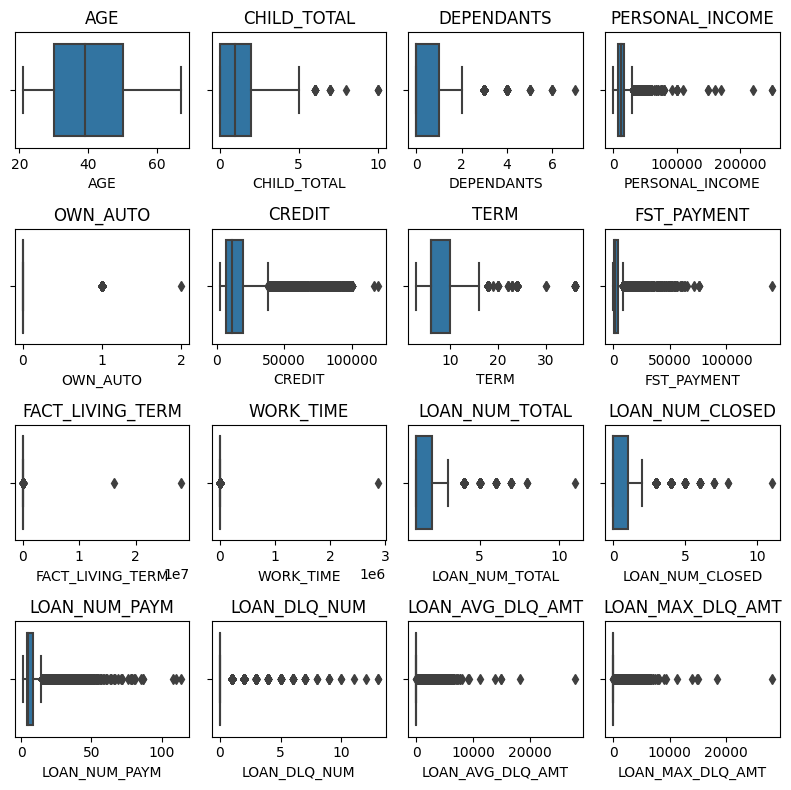

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

outliers = list(df_num.columns)

i = 0

for x in range(4):
    for y in range(4):
        
        if i <= len(outliers) - 1:
    
            sns.boxplot(data = train,
                        x = outliers[i],
                       ax = axes[x, y])

            axes[x, y].set_title(outliers[i])

        i += 1
        
fig.tight_layout()
plt.show()

### Ручная обработка выбросов

In [17]:
train[df_num.columns].agg(['min', 'max', 'median'])

AGE  CHILD_TOTAL  DEPENDANTS  PERSONAL_INCOME  OWN_AUTO    CREDIT  \
min     21.0          0.0         0.0             24.0       0.0    2000.0   
max     67.0         10.0         7.0         250000.0       2.0  119700.0   
median  39.0          1.0         0.0          12000.0       0.0   11550.0   

        TERM  FST_PAYMENT  FACT_LIVING_TERM  WORK_TIME  LOAN_NUM_TOTAL  \
min      3.0          0.0             -26.0        1.0             1.0   
max     36.0     140000.0        28101997.0  2867959.0            11.0   
median   6.0       2000.0             108.0       48.0             1.0   

        LOAN_NUM_CLOSED  LOAN_NUM_PAYM  LOAN_DLQ_NUM  LOAN_AVG_DLQ_AMT  \
min                 0.0            1.0           0.0               0.0   
max                11.0          114.0          13.0           28012.2   
median              0.0            5.0           0.0               0.0   

        LOAN_MAX_DLQ_AMT  
min                  0.0  
max              28012.2  
median               0.0

In [18]:
# убираю отрицательные значения по количеству месяцев проживания
train.FACT_LIVING_TERM = abs(train.FACT_LIVING_TERM)

Не считаем за выбросы значения по следующим признакам: <br>
<ul>
 <li>AGE - нет выбросов </li>
 <li>CHILD_TOTAL - 6 и более детей не выброс, но аномально большое число </li>
 <li>DEPENDANTS - нет выбросов, но есть аномально большие значения</li>
 <li>OWN_AUTO - человек может владеть 2 машинами</li>
 <li>TERM - срок кредита 36 месяцев (3 года) реален </li> 
 </ul>
 
Очевидно есть выбросы по следующим признакам: <br>
<ul>
 <li>FST_PAYMENT</li>
 <li>FACT_LIVING_TERM</li>
 <li>WORK_TIME</li>
 <li>LOAN_NUM_PAYM</li>
 <li>LOAN_AVG_DLQ_AMT</li> 
 <li>LOAN_MAX_DLQ_AMT</li> 
 </ul>
 
 По всем остальным столбцам присутствуют реальные, но аномально высокие значения.

In [19]:
high_income = len(train[train.PERSONAL_INCOME > 200000])
high_payment = len(train[train.FST_PAYMENT > 100000])
print(f'Число людей с доходом более 200 000 руб: {high_income}.\nЧисло людей с первоначальным взносом более 100 000 руб: {high_payment}')

Число людей с доходом более 200 000 руб: 3.
Число людей с первоначальным взносом более 100 000 руб: 1


In [20]:
# личный доход клиента более 200 000 будем считать выбросом
# первоначальный взнос более 100 000 будем считать выбросом
train.drop(train[(train.PERSONAL_INCOME > 200000)|(train.FST_PAYMENT > 100000)].index, inplace=True)

In [21]:
# будем считать, что стаж (WORK_TIME) идёт, начиная с 14 лет
# посмотрим, есть ли такие наблюдения, где стаж больше трудоспособного возраста 
len(train[train.AGE - 14 < train.WORK_TIME//12])

36

In [22]:
# посмотрим, есть ли такие наблюдения, где кол-во месяцев проживания больше возраста человека
len(train[train.AGE < train.FACT_LIVING_TERM//12])

35

In [23]:
# найденные выше наблюдения - выбросы. 
# их немного, поэтому можно удалить
train.drop(train[(train.AGE < train.FACT_LIVING_TERM//12)|(train.AGE - 14 < train.WORK_TIME//12)].index, inplace=True)

Остальные выбросы будут обработаны при помощи IsolationForest

### Применение IsolationForest

In [24]:
df_num = train.drop(not_num, axis = 1)

In [25]:
# обучение модели и предсказание
isolf = IsolationForest(contamination=0.05)
outliers = isolf.fit_predict(df_num.values)

# число аномалий в выборке
list(outliers).count(-1)

758

In [26]:
# удаление найденных выбросов
train['outliers'] = outliers
train.drop(train[train['outliers'] == -1].index, inplace=True)
train.drop('outliers', axis=1, inplace=True)

In [27]:
# статистика после удаления выбросов
train[df_num.columns].agg(['min', 'max', 'median'])

AGE  CHILD_TOTAL  DEPENDANTS  PERSONAL_INCOME  OWN_AUTO    CREDIT  \
min     21.0          0.0         0.0             24.0       0.0    2000.0   
max     67.0         10.0         7.0         160000.0       2.0  119700.0   
median  39.0          1.0         0.0          12000.0       0.0   11290.0   

        TERM  FST_PAYMENT  FACT_LIVING_TERM  WORK_TIME  LOAN_NUM_TOTAL  \
min      3.0          0.0               0.0        1.0             1.0   
max     36.0      50000.0             720.0      528.0             7.0   
median   6.0       2000.0             105.0       48.0             1.0   

        LOAN_NUM_CLOSED  LOAN_NUM_PAYM  LOAN_DLQ_NUM  LOAN_AVG_DLQ_AMT  \
min                 0.0            1.0           0.0               0.0   
max                 7.0           71.0           9.0            4650.0   
median              0.0            5.0           0.0               0.0   

        LOAN_MAX_DLQ_AMT  
min                  0.0  
max               4650.0  
median               0.0

In [28]:
y_train = train['TARGET']
train.drop('TARGET', axis=1, inplace=True)

## Кодирование категориальных переменных

In [29]:
df1 = copy.deepcopy(train)

In [30]:
for cat in category:
  print(f'{cat}: {df1[cat].nunique()}')

EDUCATION: 7
MARITAL_STATUS: 5
GEN_INDUSTRY: 32
GEN_TITLE: 12
ORG_TP_STATE: 5
ORG_TP_FCAPITAL: 2
JOB_DIR: 10
FAMILY_INCOME: 5
TP_PROVINCE: 72


In [31]:
# посмотрим есть ли признаки с единственным значнием 
# и какие категориальные признаки имеют большое кол-во категорий
for column in df1.columns:
    if column not in to_delete:
        q = df1[column].nunique()
        if q == 1 or (q > 10 and column in category):
            print(f'{column}: {q}')

GEN_INDUSTRY: 32
GEN_TITLE: 12
TP_PROVINCE: 72
DL_DOCUMENT_FL: 1


Признак DL_DOCUMENT_FL необходимо удалить. <br>
По остальным признакам сократим кол-во категорий при помощи биннинга.

In [32]:
# удаление неуникального признака
to_delete.append('DL_DOCUMENT_FL')
df1.drop('DL_DOCUMENT_FL', axis=1, inplace=True)
test.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

In [33]:
df1.reset_index(drop=True, inplace=True)

In [34]:
pip install optbinning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 27.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [35]:
from optbinning import BinningProcess

(CVXPY) Jun 12 09:16:41 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 12 09:16:41 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [36]:
variables = ['GEN_INDUSTRY', 'GEN_TITLE', 'TP_PROVINCE']
x = df1[variables]

binning_process = BinningProcess(variables, 
                                 selection_criteria = {'iv': {'min': 0.02}}, 
                                 max_n_bins=15)
binning_process.fit(x, y_train)

BinningProcess(max_n_bins=15, selection_criteria={'iv': {'min': 0.02}},
               variable_names=['GEN_INDUSTRY', 'GEN_TITLE', 'TP_PROVINCE'])

In [37]:
binning_process.summary()

name        dtype   status  selected n_bins        iv        js  \
0  GEN_INDUSTRY  categorical  OPTIMAL      True     10  0.169151  0.020367   
1     GEN_TITLE  categorical  OPTIMAL      True      5  0.107365  0.012904   
2   TP_PROVINCE  categorical  OPTIMAL      True     14  0.127482  0.015727   

       gini quality_score  
0  0.198222      0.000023  
1   0.13507      0.107641  
2   0.19988      0.000001

Значение IV для признака GEN_INDUSTRY равно 0.1692.


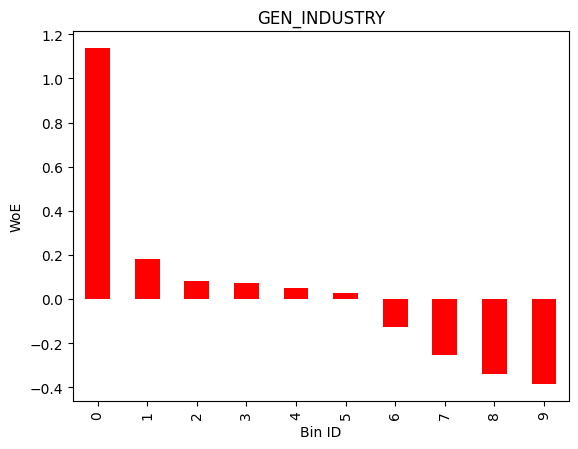

Значение IV для признака GEN_TITLE равно 0.1074.


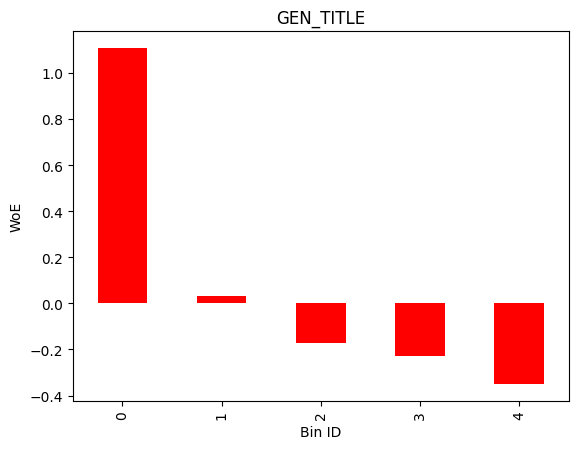

Значение IV для признака TP_PROVINCE равно 0.1275.


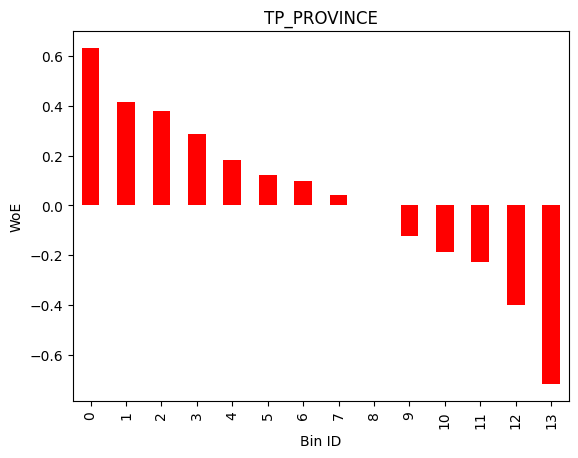

In [38]:
bin_sum = binning_process.summary()

for col in variables:
    binned = binning_process.get_binned_variable(col)
    iv = round(float(bin_sum[bin_sum.name == col].iv), 4)
    
    table = binned.binning_table.build()[:-1]
    table.drop(table[table.WoE == 0.0].index, inplace=True)
    
    print(f'Значение IV для признака {col} равно {iv}.')
    table['WoE'] = table['WoE'].astype(float)
    table.WoE.plot(kind='bar', color='red', xlabel = 'Bin ID', ylabel = 'WoE')
    plt.title(col)
    plt.show()

Все три признака имеют среднюю пресказательную силу.

Значение IV для признака GEN_INDUSTRY равно 0.1689.


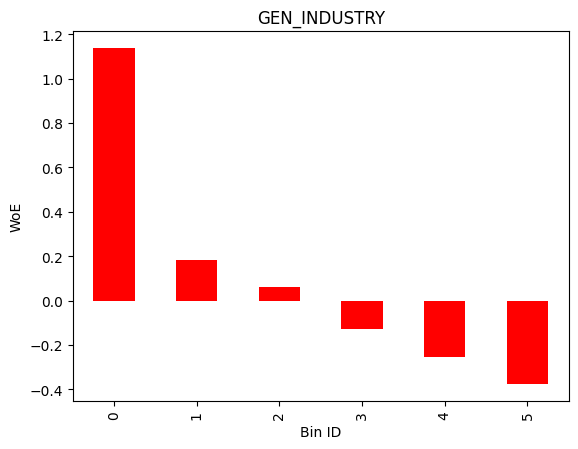

Значение IV для признака GEN_TITLE равно 0.1074.


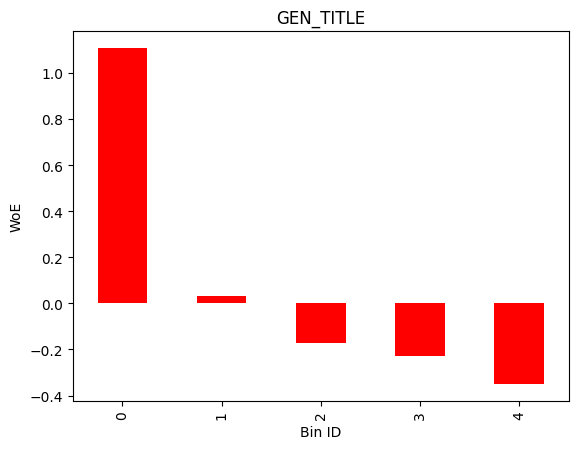

Значение IV для признака TP_PROVINCE равно 0.1273.


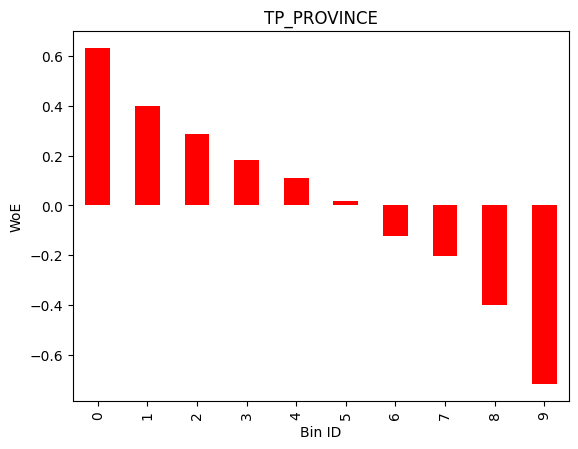

In [39]:
# сокращение числа биннов
new = [6, 5, 10]

i = 0

models = []

while i < 3:
    
    binning_process = BinningProcess(variables, 
                                     selection_criteria = {'iv': {'min': 0.02}}, 
                                     max_n_bins=new[i])
    
    binning_process.fit(x, y_train)

    bin_sum = binning_process.summary()

    binned = binning_process.get_binned_variable(variables[i])
    
    models.append(binned)
    
    iv = round(float(bin_sum[bin_sum.name == variables[i]].iv), 4)

    table = binned.binning_table.build()[:-1]
    table.drop(table[table.WoE == 0.0].index, inplace=True)

    print(f'Значение IV для признака {variables[i]} равно {iv}.')
    table['WoE'] = table['WoE'].astype(float)
    table.WoE.plot(kind='bar', color='red', xlabel = 'Bin ID', ylabel = 'WoE')
    plt.title(variables[i])
    plt.show()
    
    i += 1

In [40]:
X_transform = binning_process.transform(df1[variables], metric='woe')
df1.drop(variables, axis=1, inplace=True)
df1 = df1.join(X_transform)

In [41]:
X_transform2 = binning_process.transform(test[variables], metric='woe')
test.drop(variables, axis=1, inplace=True)
test = test.join(X_transform2)

Остальные признаки закодирую при помощи BinaryEncoder

In [42]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


In [43]:
import category_encoders as ce

# кодирование категориальных переменных
encoder = ce.CountEncoder()
x_train = encoder.fit_transform(df1)
x_test = encoder.transform(test)

In [44]:
# проверка размерности перед обучением
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(14393, 40)
(14393,)
(14910, 40)
(14910,)


# Построение модели

### Модель случайного леса

In [45]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
display(rfc.score(x_train, y_train))

1.0

In [46]:
rfc_pred1 = rfc.predict(x_test)

# Прогнозирование вероятностей для тестовых данных.
rfc_proba1 = rfc.predict_proba(x_test)
rfc_proba1

array([[0.89, 0.11],
       [0.98, 0.02],
       [0.88, 0.12],
       ...,
       [0.88, 0.12],
       [1.  , 0.  ],
       [0.86, 0.14]])

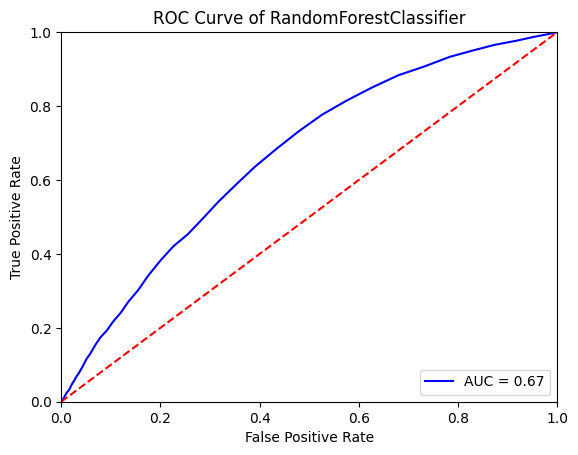

In [47]:
# Сохраняем вероятности только положительного класса.
fpr, tpr, thresholds = roc_curve(y_test, rfc_proba1[:,1], drop_intermediate=False)

# графически

RFC = roc_auc_score(y_test, rfc_proba1[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % RFC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of RandomForestClassifier')
plt.show()

In [51]:
from sklearn.model_selection import RandomizedSearchCV

In [52]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(x_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 18,
 'min_samples_leaf': 39,
 'max_features': 'log2',
 'max_depth': 2,
 'bootstrap': True}

In [56]:
rfc2 = RandomForestClassifier(n_estimators=300,
    min_samples_split=18,
    min_samples_leaf=39,
    max_features='log2',
    max_depth=2,
    bootstrap=True)

rfc2.fit(x_train, y_train)
display(rfc2.score(x_train, y_train))

0.8829986799138471

In [57]:
rfc_pred2 = rfc2.predict(x_test)

# Прогнозирование вероятностей для тестовых данных.
rfc_proba2 = rfc2.predict_proba(x_test)
rfc_proba2

array([[0.88391858, 0.11608142],
       [0.94216234, 0.05783766],
       [0.88305611, 0.11694389],
       ...,
       [0.87399579, 0.12600421],
       [0.93497757, 0.06502243],
       [0.84087201, 0.15912799]])

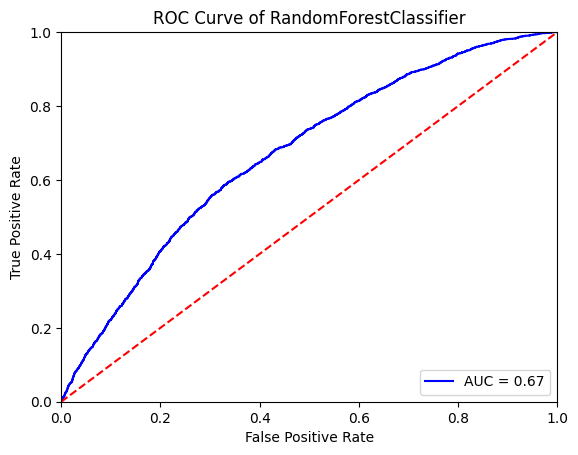

In [58]:
# Сохраняем вероятности только положительного класса.
fpr, tpr, thresholds = roc_curve(y_test, rfc_proba2[:,1], drop_intermediate=False)

# графически

RFC = roc_auc_score(y_test, rfc_proba2[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % RFC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of RandomForestClassifier')
plt.show()

### Модель градиентного бустинга

In [48]:
gbc = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5,
    random_state=123)

gbc.fit(x_train, y_train)
gbc_pred = gbc.predict(x_test)

In [49]:
# Прогнозирование вероятностей для тестовых данных.
gbc_proba = gbc.predict_proba(x_test)
gbc_proba

array([[0.9064316 , 0.0935684 ],
       [0.98459322, 0.01540678],
       [0.90562268, 0.09437732],
       ...,
       [0.89443269, 0.10556731],
       [0.96111543, 0.03888457],
       [0.64618998, 0.35381002]])

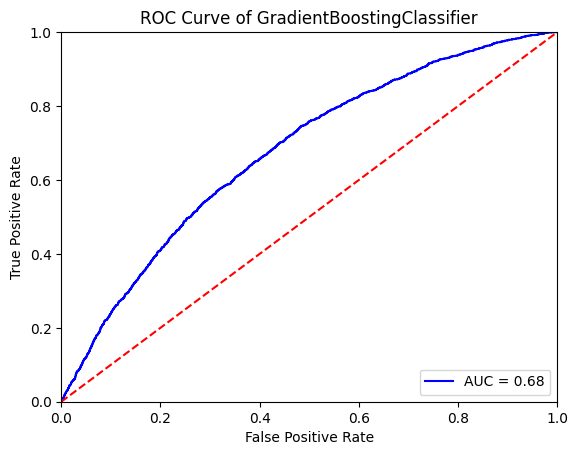

In [50]:
# Сохраняем вероятности только положительного класса.
fpr, tpr, thresholds = roc_curve(y_test, gbc_proba[:,1], drop_intermediate=False)

# графически

GBC = roc_auc_score(y_test, gbc_proba[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % GBC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of GradientBoostingClassifier')
plt.show()

Лучше всего показала себя модель градиентного бустинга. Для неё метрика AUC составила 0.68, что является хорошим результатом.